# 0. Setup Paths

In [ ]:
!pip install tensorflow==2.7.0
!pip install tensorflow-addons
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 22 kB/s 
     |████████████████████████████████| 1.3 MB 7.2 MB/s 
     |████████████████████████████████| 463 kB 71.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab202207

In [ ]:
import os
import shutil
import gc
import numpy as np
import random
from collections import deque
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, ELU, Reshape, Concatenate, Activation, Flatten, Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from matplotlib import pyplot as plot
import keras.backend as K
import xml.etree.ElementTree as ET
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'ARMAS_PATH': os.path.join('Tensorflow', 'workspace','armas'),
 }

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Preprocesamiento de imágenes

Librería para preprocesar las imágenes sin perder las anotaciones de las bounding boxes

In [ ]:
!git clone https://github.com/Paperspace/DataAugmentationForObjectDetection

Cloning into 'DataAugmentationForObjectDetection'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 141 (delta 10), reused 8 (delta 8), pack-reused 122
Receiving objects: 100% (141/141), 10.19 MiB | 4.46 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
os.chdir('/content/DataAugmentationForObjectDetection')
from data_aug.bbox_util import *
from data_aug.data_aug import *

Repo con el dataset

In [ ]:
os.chdir('/content')

In [ ]:
!git clone https://github.com/jeffpr11/ia_g11_gunsdetector

Cloning into 'ia_g11_gunsdetector'...
remote: Enumerating objects: 6060, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6060 (delta 5), reused 12 (delta 3), pack-reused 6040
Receiving objects: 100% (6060/6060), 240.28 MiB | 38.06 MiB/s, done.
Resolving deltas: 100% (3013/3013), done.
Checking out files: 100% (6024/6024), done.


Se mueve las imágenes y las annotations al archivo correcto

In [ ]:
os.chdir('/content/ia_g11_gunsdetector/armas')
dst_dir = "/content/Tensorflow/workspace/armas"
count = 0
for f in os.listdir():
    count+=1
    shutil.copy(f, dst_dir)
print("Archivos copiados: " + str(count))

os.chdir('/content/ia_g11_gunsdetector/xmls')
dst_dir = "/content/Tensorflow/workspace/annotations"
count = 0
for f in os.listdir():
    count+=1
    shutil.copy(f, dst_dir)
print("Archivos copiados: " + str(count))

Archivos copiados: 3000
Archivos copiados: 3000


Se regresa al directorio inicial

In [ ]:
os.chdir('/content')

In [ ]:
def getBbox(xmlfile):
    tree = ET.parse(xmlfile)
    root = tree.getroot()
    gun = root.findall('object')[0]
    bbox = gun.find('bndbox')
    x1 = float(bbox.find('xmin').text)
    x2 = float(bbox.find('xmax').text)
    y1 = float(bbox.find('ymin').text)
    y2 = float(bbox.find('ymax').text)
    result = [x1, y1, x2, y2] #[gunClass, bgClass, x1, y1, x2, y2]
    return result

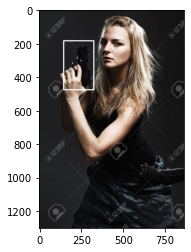

In [ ]:
img = cv2.imread("/content/Tensorflow/workspace/armas/armas (9).jpg")[:,:,::-1]
bbox = getBbox("/content/Tensorflow/workspace/annotations/armas (9).xml")

plotted_img = draw_rect(img, np.array([bbox]))
plt.imshow(plotted_img)
plt.show()

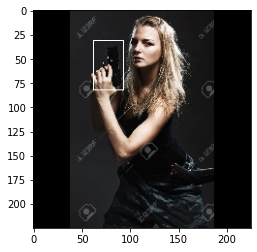

In [ ]:
img_, bboxes_ = Resize(225)(img.copy(), np.array([bbox]).copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

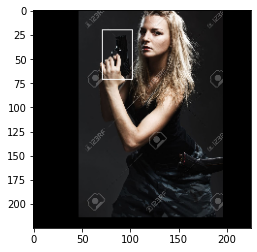

In [ ]:
img_, bboxes_ = RandomTranslate(0.1, diff = True)(img_.copy(), bboxes_.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

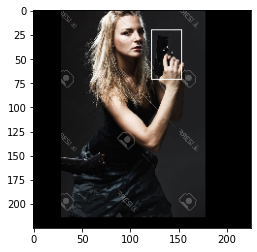

In [ ]:
img_aug, bboxes_aug = RandomHorizontalFlip(1)(img_.copy(), bboxes_.copy())
plotted_img = draw_rect(img_aug, bboxes_aug)
plt.imshow(plotted_img)
plt.show()

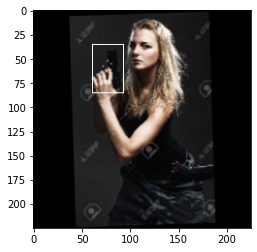

In [ ]:
img_aug, bboxes_aug = RandomRotate(20)(img_.copy(), bboxes_.copy())
plotted_img = draw_rect(img_aug, bboxes_aug)
plt.imshow(plotted_img)
plt.show()

In [ ]:
#Prep de data
train_imgs = []
valid_imgs = []
test_imgs = []
train_annot = []
valid_annot = []
test_annot = []

#Orden al azar de imágenes
order_list = list(range(1,3001))
random.shuffle(order_list)
order_queue = deque(order_list)

#Recorrer el orden al azar para train set (2100 items)
for i in range(2100):
  num = order_queue.pop()
  img_file = "/content/Tensorflow/workspace/armas/armas (" + str(num) + ").jpg"
  annot_file = "/content/Tensorflow/workspace/annotations/armas (" + str(num) + ").xml"
  img = cv2.imread(img_file)[:,:,::-1]
  bbox = np.array([getBbox(annot_file)])
  img_, bbox_ = Resize(225)(img.copy(), bbox.copy())
  img_, bbox_ = RandomTranslate(0.05, diff = True)(img_.copy(), bbox_.copy())
  train_imgs.append(img_)
  train_annot.append(bbox_[0])

In [ ]:
train_imgs = np.array(train_imgs)/255.0
train_annot = np.array(train_annot)/225.0
#train_lbl = np.array(train_lbl)

#Recorrer el orden al azar para valid set (420 items)
for i in range(420):
  num = order_queue.pop()
  img_file = "/content/Tensorflow/workspace/armas/armas (" + str(num) + ").jpg"
  annot_file = "/content/Tensorflow/workspace/annotations/armas (" + str(num) + ").xml"
  img = cv2.imread(img_file)[:,:,::-1]
  bbox = np.array([getBbox(annot_file)])
  img_, bbox_ = Resize(225)(img.copy(), bbox.copy())
  img_, bbox_ = RandomTranslate(0.05, diff = True)(img_.copy(), bbox_.copy())
  valid_imgs.append(img_)
  valid_annot.append(bbox_[0])

In [ ]:
valid_imgs = np.array(valid_imgs)/255.0
valid_annot = np.array(valid_annot)/225.0

#Recorrer el orden al azar para test set (210 items)
for i in range(210):
  num = order_queue.pop()
  img_file = "/content/Tensorflow/workspace/armas/armas (" + str(num) + ").jpg"
  annot_file = "/content/Tensorflow/workspace/annotations/armas (" + str(num) + ").xml"
  img = cv2.imread(img_file)[:,:,::-1]
  bbox = np.array([getBbox(annot_file)])
  img_, bbox_ = Resize(225)(img.copy(), bbox.copy())
  img_, bbox_ = RandomTranslate(0.05, diff = True)(img_.copy(), bbox_.copy())
  test_imgs.append(img_)
  test_annot.append(bbox_[0])

In [ ]:
test_imgs = np.array(test_imgs)/255.0
test_annot = np.array(test_annot)/225.0

order_list = []
order_queue = []
gc.collect()

print(test_annot)
os.chdir('/content')

[[2.70763126e-01 4.41916972e-01 4.01257631e-01 5.40818071e-01]
 [1.26388889e-02 1.77083333e-01 9.31388889e-01 8.39583333e-01]
 [3.23308271e-01 2.83709273e-01 5.26315789e-01 4.75438596e-01]
 [4.95782828e-01 2.24520202e-01 5.90479798e-01 2.83232323e-01]
 [3.74157014e-01 4.12269412e-01 4.39794080e-01 5.86014586e-01]
 [0.00000000e+00 1.23611111e-01 9.74166667e-01 8.23611111e-01]
 [4.77555556e-01 3.53333333e-01 5.37555556e-01 3.89333333e-01]
 [1.55555556e-01 3.22222222e-01 8.85555556e-01 6.62222222e-01]
 [5.65000000e-01 3.78333333e-01 6.56666667e-01 5.20000000e-01]
 [3.33333333e-03 2.12222222e-01 9.90000000e-01 7.05555556e-01]
 [1.92888889e-01 3.54888889e-01 9.06888889e-01 8.36888889e-01]
 [8.88888889e-04 1.46222222e-01 9.58888889e-01 8.20222222e-01]
 [2.84722222e-02 1.61805556e-01 9.90972222e-01 8.74305556e-01]
 [2.17777778e-01 4.40000000e-01 3.06666667e-01 6.04444444e-01]
 [1.41562500e-01 3.96840278e-01 2.22812500e-01 4.53090278e-01]
 [7.26937669e-01 4.13550136e-01 9.31815718e-01 5.924119

# 2. Implementación del modelo

In [ ]:
img_height = 225
img_width = 225
img_channels = 3
num_clases = 2

In [ ]:
x1 = Input(shape=(img_height, img_width, img_channels))

conv1 = Conv2D(32, (5, 5), strides=(1, 1), padding="same", kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01), name='conv1')(x1)
relu1 = Activation('relu', name="relu1")(conv1)
conv2 = Conv2D(32, (5, 5), strides=(1, 1), padding="same", kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01), name='conv2')(relu1)
batch_norm1 = BatchNormalization()(conv2)
relu2 = Activation('relu', name="relu2")(batch_norm1)
drop1 = Dropout(0.3)(relu2)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(drop1)

conv3 = Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01), name='conv3')(pool1)
relu3 = Activation('relu', name="relu3")(conv3)
conv4 = Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01), name='conv4')(relu3)
batch_norm2 = BatchNormalization()(conv4)
relu4 = Activation('relu', name="relu4")(batch_norm2)
drop2 = Dropout(0.3)(relu4)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(drop2)

conv5 = Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01), name='conv5')(pool2)
relu5 = Activation('relu', name="relu5")(conv5)
conv6 = Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01), name='conv6')(relu5)
batch_norm3 = BatchNormalization()(conv6)
relu6 = Activation('relu', name="relu6")(batch_norm3)
drop3 = Dropout(0.3)(relu6)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(drop3)

conv7 = Conv2D(256, (3, 3), strides=(1, 1), padding="same", kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01), name='conv7')(pool3)
relu7 = Activation('relu', name="relu7")(conv7)
conv8 = Conv2D(256, (3, 3), strides=(1, 1), padding="same", kernel_initializer=GlorotNormal(), kernel_regularizer=l2(0.01), name='conv8')(relu7)
batch_norm4 = BatchNormalization()(conv8)
relu8 = Activation('relu', name="relu8")(batch_norm4)
drop4 = Dropout(0.3)(relu8)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(drop4)

flat = Flatten(name="flat")(pool4)

#Bounding Box Predictor

box_dense1 = Dense(units=128, activation="relu", name="box_dense1")(flat)
drop6 = Dropout(0.3)(box_dense1)
box_dense2 = Dense(units=64, activation="relu", name="box_dense2")(drop6)
box_dense3 = Dense(units=32, activation="relu", name="box_dense3")(box_dense2)
box_pred = Dense(units=4, activation="sigmoid", name="box_pred")(box_dense3)

model = Model(inputs=x1, outputs=box_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 225, 225, 32)      2432      
                                                                 
 relu1 (Activation)          (None, 225, 225, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 225, 225, 32)      25632     
                                                                 
 batch_normalization (BatchN  (None, 225, 225, 32)     128       
 ormalization)                                                   
                                                                 
 relu2 (Activation)          (None, 225, 225, 32)      0         
                                                             

In [ ]:
def iou(y_true, y_pred):
    AofT = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    AofP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    traslape0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    traslape1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    traslape2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    traslape3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    intersection = (1 + traslape2 - traslape0) * (1 + traslape3 - traslape1)

    union = AofT + AofP - intersection

    iou = K.clip(intersection / union, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou 

def iou_metric(y_true, y_pred):
    return iou(y_true, y_pred)

def iou_loss(y_true, y_pred):
    return -K.log(iou(y_true, y_pred))

In [ ]:
opt = Adam(learning_rate=0.000001, amsgrad=True)
model.compile(loss=iou_loss, metrics=iou_metric, optimizer=opt)

# 3. Entrenamiento del modelo

In [ ]:
history = model.fit(x=train_imgs, y=train_annot, validation_data=(valid_imgs, valid_annot), epochs=70, verbose=2)

Epoch 1/70
66/66 - 16s - loss: 8.5178 - iou_metric: 0.5301 - val_loss: 8.5723 - val_iou_metric: 0.4936 - 16s/epoch - 249ms/step
Epoch 2/70
66/66 - 14s - loss: 8.3037 - iou_metric: 0.6432 - val_loss: 8.4602 - val_iou_metric: 0.5442 - 14s/epoch - 212ms/step
Epoch 3/70
66/66 - 14s - loss: 8.2561 - iou_metric: 0.6716 - val_loss: 8.3986 - val_iou_metric: 0.5723 - 14s/epoch - 212ms/step
Epoch 4/70
66/66 - 14s - loss: 8.2436 - iou_metric: 0.6761 - val_loss: 8.3695 - val_iou_metric: 0.5840 - 14s/epoch - 211ms/step
Epoch 5/70
66/66 - 14s - loss: 8.2285 - iou_metric: 0.6820 - val_loss: 8.3443 - val_iou_metric: 0.5939 - 14s/epoch - 209ms/step
Epoch 6/70
66/66 - 14s - loss: 8.2097 - iou_metric: 0.6893 - val_loss: 8.3216 - val_iou_metric: 0.6024 - 14s/epoch - 208ms/step
Epoch 7/70
66/66 - 14s - loss: 8.1967 - iou_metric: 0.6929 - val_loss: 8.3079 - val_iou_metric: 0.6058 - 14s/epoch - 208ms/step
Epoch 8/70
66/66 - 14s - loss: 8.1875 - iou_metric: 0.6941 - val_loss: 8.2881 - val_iou_metric: 0.6126 -

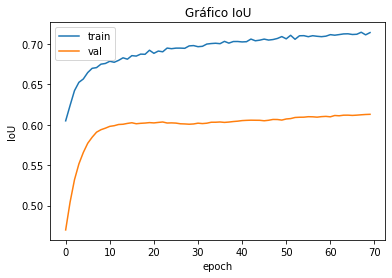

In [ ]:
plt.plot(history.history['iou_metric'])
plt.plot(history.history['val_iou_metric'])
plt.title('Gráfico IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

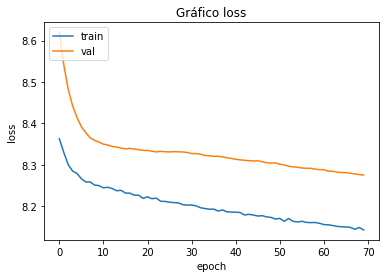

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Solo ejecutar para grabar modelo
name = "modelo3"
model.save("/content/Tensorflow/models/"+name, save_format='h5')

In [ ]:
#Ejecutar para copiar el modelo al drive
%cp -r /content/Tensorflow/models/modelo3 /gdrive/MyDrive

In [ ]:
#Solo ejecutar para eliminar modelo actual
K.clear_session()
gc.collect()

13491

**3.1 Convertir modelo a json**

In [ ]:
command = "tensorflowjs_converter --input_format=keras /content/Tensorflow/models/modelo3 /content/Tensorflow/tfjsexport/"

In [ ]:
!{command}

In [ ]:
%cp -r /content/Tensorflow/tfjsexport /gdrive/MyDrive

# 4. Predicción demo

In [ ]:
test_targets = {
#	"class_softmax": test_lbl,
	"box_pred": test_annot
}
num = random.randint(0,96)
img_test = test_imgs[num]
annot_test = test_annot[num]

img = cv2.imread("/content/Tensorflow/workspace/armas/armas (9).jpg")[:,:,::-1]
img,bbox = Resize(225)(img.copy(), np.array([[0.0,0.0,0.0,0.0]]).copy())
'''
eval = model.evaluate(test_imgs, test_annot, verbose=2)
predictions = model.predict(np.array([img_test]))

#print(predictions[0][num])
print(predictions[0]*225.0)
print(annot_test*225.0)

plotted_img = draw_rect(img_test, np.array([predictions[0]])*225.0, color=[255, 0, 0])
plt.imshow(plotted_img)
plt.show()'''

'\neval = model.evaluate(test_imgs, test_annot, verbose=2)\npredictions = model.predict(np.array([img_test]))\n\n#print(predictions[0][num])\nprint(predictions[0]*225.0)\nprint(annot_test*225.0)\n\nplotted_img = draw_rect(img_test, np.array([predictions[0]])*225.0, color=[255, 0, 0])\nplt.imshow(plotted_img)\nplt.show()'

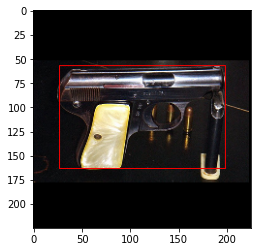

In [ ]:
plotted_img = draw_rect(img_test, np.array([annot_test])*225.0, color=[255, 0, 0])
plt.imshow(plotted_img)
plt.show()

[ 70.61329  67.50276 148.60701 129.75452]
[138.42307692  54.13461538 185.84615385  87.71153846]


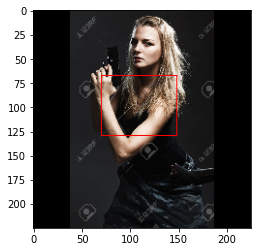

In [ ]:
#Solo para probar el modelo cargado en el drive
model2 = load_model('/gdrive/MyDrive/modelo3', custom_objects={'iou_loss': iou_loss, 'iou_metric': iou_metric})

#eval = model2.evaluate(test_imgs, test_annot, verbose=2)
predictions = model2.predict(np.array([img])/255.0)

#print(predictions[0][num])
print(predictions[0]*225.0)
print(annot_test*225.0)

plotted_img = draw_rect(img, np.array([predictions[0]])*225.0, color=[255, 0, 0])
plt.imshow(plotted_img)
plt.show()